In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Importing the Keras libraries and packages
from keras.models import Sequential  
from keras.models import Model
from keras.layers import Dense 
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import Input

In [2]:
def Data_set_spliting(train_data,test_data,val_size,n_timestep):
    train_data_size = train_data.shape[0]
    train_set = train_data[:train_data_size - val_size] 
    val_set = train_data[train_data_size - val_size - n_timestep:]
    test_set = np.concatenate((train_data[train_data_size-n_timestep:],test_data),axis=0)
    
    return train_set,val_set,test_set

In [3]:
def Data_scaling(train_set,val_set,test_set):
    
    scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler
    train_scaled = scaler.fit_transform(train_set) # applying to Scaler to train
    val_scaled = scaler.transform(val_set)
    test_scaled = scaler.transform(test_set)
    
    return train_scaled,val_scaled,test_scaled,scaler

In [4]:
# We add first 50 data to "X_train" and the 51 close price to "y_train" .

def generate_input_data(data_set, n_timestep):

    X = []
    y = []

    for i in range(n_timestep, data_set.shape[0]):
        X.append(data_set[i-n_timestep:i,:])
        y.append(data_set[i,:])

    X, y = np.array(X), np.array(y)

    #y_train = y_train.reshape((len(y_train),1))

    #Print(X_train)
    #print(X_train.shape)
    #Print(y_train)
    #print(y_train.shape)
    return X, y

In [5]:
def base_model(RNN_cell,n_hidden_unit, n_timestep, n_layer, dropout = 0, n_feature = 5):
    model = Sequential()
    
    if n_layer == 1:
        model.add(RNN_cell(units = n_hidden_unit, return_sequences = False,
                                dropout = dropout, input_shape = (n_timestep, n_feature)))
    else:
        for i in range(n_layer):
            if i == 0: #first layer
                model.add(RNN_cell(units = n_hidden_unit, return_sequences = True,
                                    dropout = dropout, input_shape = (n_timestep, n_feature)))
            elif i!= n_layer-1: #last layer
                model.add(RNN_cell(units = n_hidden_unit, return_sequences = True,
                                    dropout = dropout))
            else: # middle layer
                model.add(RNN_cell(units = n_hidden_unit, return_sequences = False,
                                    dropout = dropout))
        

    model.add(Dense(units = n_feature))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return model

In [70]:
import time
def Model_fit_pipeline(X_train, y_train,X_val,val_set, 
                       RNN_cell, n_timestep, 
                       n_hidden_unit_list = n_hidden_unit_list, n_layer_list = n_layer_list):
    MSE = 0
    RMSE = 0
    lowest_RMSE = 100
    RMSE_list = []
    
    start_time = time.time()
    for n_hidden_unit in n_hidden_unit_list:
        temp_RMSE_list = []
        for n_layer in n_layer_list:
            
            model = base_model(RNN_cell = RNN_cell,n_hidden_unit = n_hidden_unit,n_layer = n_layer, n_timestep = n_timestep, n_feature = 5)
            #model.summary()
            history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs = 100, batch_size = 24,verbose=0)

            y_pred = model.predict_step(X_val)
            y_pred = scaler.inverse_transform(y_pred)
            MSE = mean_squared_error(val_set[n_timestep:,3],y_pred[:,3])
            RMSE = np.sqrt(MSE)
            temp_RMSE_list.append(RMSE)
            if RMSE < lowest_RMSE:
                lowest_RMSE = RMSE
                best_hyperparameter_list = [n_hidden_unit,n_layer]
                best_pred = y_pred
                best_model = model
                best_history = history
        RMSE_list.append(temp_RMSE_list)
    end_time = time.time()
    run_time = end_time - start_time
    
    np_RMSE_list = np.asarray(RMSE_list)
    
    return best_model,best_pred,lowest_RMSE,best_history,best_hyperparameter_list, np_RMSE_list, run_time

In [7]:
cols = ['Open','High','Low','Close','Volume']
df_trian_data = pd.read_csv('Google_Stock_Price_Train.csv',usecols = cols,sep=",",dtype = np.float64,thousands=',')
df_test_data = pd.read_csv('Google_Stock_Price_Test.csv',usecols = cols,sep=",",dtype = np.float64,thousands=',')
train_data = df_trian_data.values
test_data = df_test_data.values

train_dataset_size = train_data.shape[0]
n_feature = train_data.shape[1]
val_size = 50

full_train_set = train_data 

print(full_train_set.shape)

(1258, 5)


In [72]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['loss'])
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Loss','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 0.01)
    plt.show() 


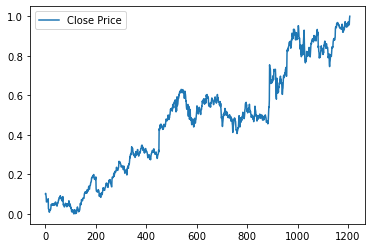

In [9]:
# feature scalling

plt.plot(train_scaled[:,3],label = 'Close Price')
plt.legend()
plt.show()

In [83]:
#Hyperparameter setting
RNN_cell_list = [SimpleRNN,GRU,LSTM]
n_timestep_list = [10,20,50,100]
n_hidden_unit_list = [10,20,50,100,200]
n_layer_list = [1,2,3,4]

In [25]:
def plot_pred(best_pred,val_set,n_timestep,RNN_cell_label):
    plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(val_set[n_timestep:,3],color="orange",label="Real value "+cols[3])
    plt.plot(best_pred[:,3],color="c",label= RNN_cell_label + "predicted result "+cols[3])
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Values")
    plt.grid(True)
    plt.show()

In [45]:
def plot_RMSE(RMSE_list,RNN_cell_label):
    plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(np.mean(RMSE_list,axis = 1),color="orange",label=RNN_cell_label + " mean RMSE with respect to n_hidden_unit")
    
    plt.plot(np.mean(RMSE_list,axis = 0),color="c",label=RNN_cell_label + " mean RMSE with respect to n_layer")
    
    plt.legend()
    plt.xlabel("Number")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

For number of timestep = 10,the best model RMSE is 9.071514068374292
For number of timestep = 10,the best hyperparameter setting is     number of hidden unit:100,number of layer:2
For number of timestep = 10,the prediction against true value


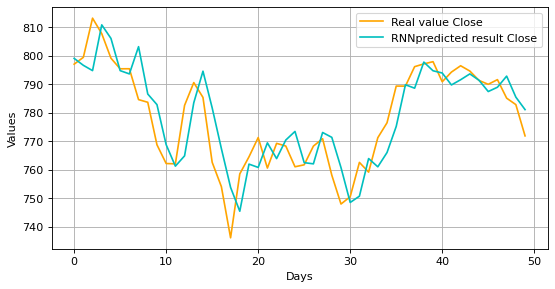

For number of timestep = 10,the RMSE plot


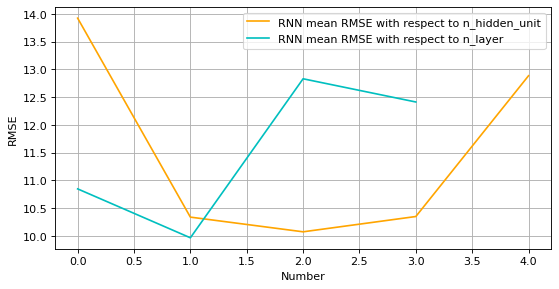

For number of timestep = 10,the training loss and val loss


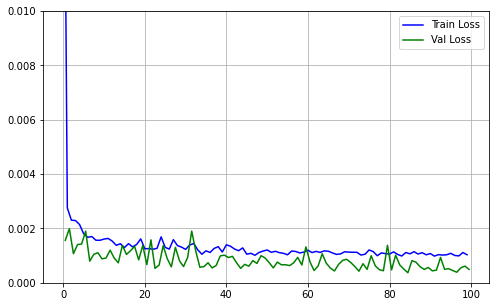

For number of timestep = 20,the best model RMSE is 8.935900852857726
For number of timestep = 20,the best hyperparameter setting is     number of hidden unit:50,number of layer:3
For number of timestep = 20,the prediction against true value


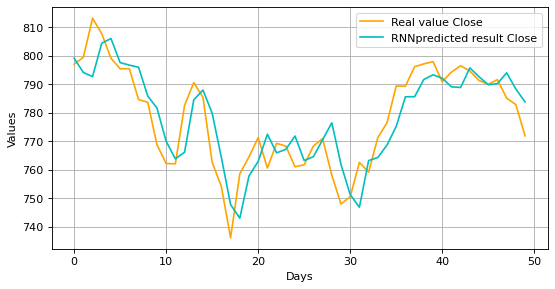

For number of timestep = 20,the RMSE plot


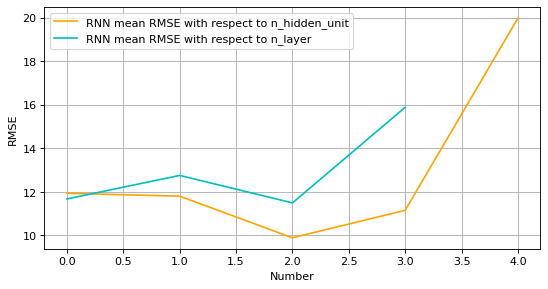

For number of timestep = 20,the training loss and val loss


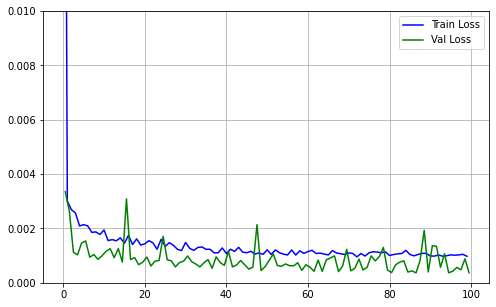

For number of timestep = 50,the best model RMSE is 8.911719798110683
For number of timestep = 50,the best hyperparameter setting is     number of hidden unit:50,number of layer:3
For number of timestep = 50,the prediction against true value


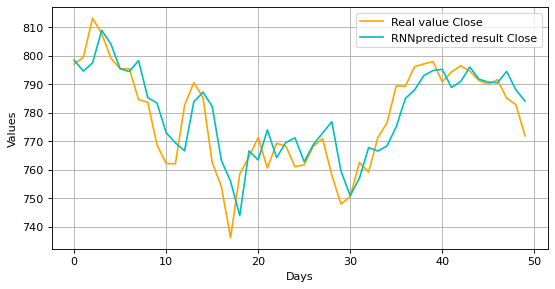

For number of timestep = 50,the RMSE plot


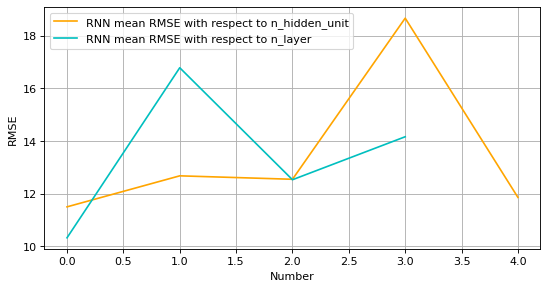

For number of timestep = 50,the training loss and val loss


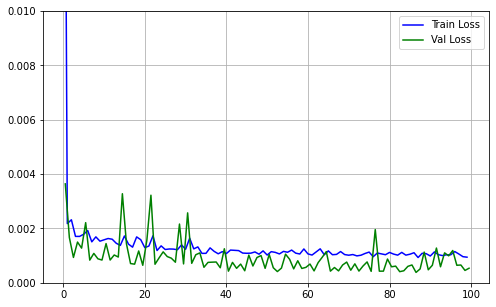

For number of timestep = 100,the best model RMSE is 9.248377080062166
For number of timestep = 100,the best hyperparameter setting is     number of hidden unit:200,number of layer:2
For number of timestep = 100,the prediction against true value


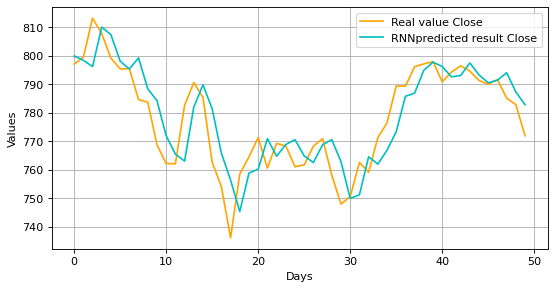

For number of timestep = 100,the RMSE plot


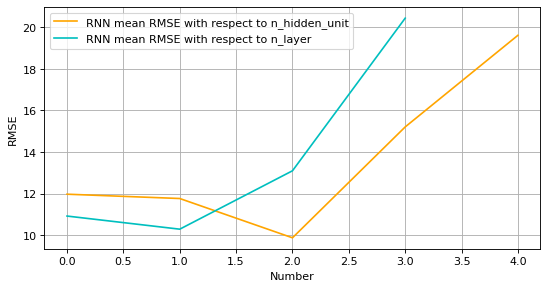

For number of timestep = 100,the training loss and val loss


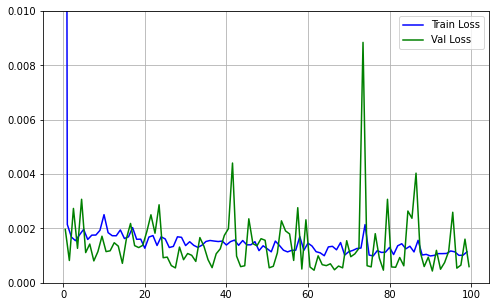

In [84]:
#For Simple RNN

for n_timestep in n_timestep_list:

    train_set,val_set,test_set = Data_set_spliting(train_data,test_data,val_size,n_timestep)
    train_scaled,val_scaled,test_scaled,scaler = Data_scaling(train_set,val_set,test_set)

    X_train, y_train = generate_input_data(train_scaled, n_timestep)
    X_val, y_val = generate_input_data(val_scaled, n_timestep)
    X_test, y_test = generate_input_data(test_scaled, n_timestep)
    
    #grid search the model with different number of hidden unit and number of layer
    best_model,best_pred,lowest_RMSE,best_history,best_hyperparameter_list, RMSE_list, run_time = Model_fit_pipeline(
        X_train = X_train, y_train = y_train, X_val= X_val, val_set = val_set, 
        RNN_cell = SimpleRNN, n_timestep = n_timestep, n_hidden_unit_list = n_hidden_unit_list, n_layer_list = n_layer_list)
    
    print(f'For number of timestep = {n_timestep},the best model RMSE is {lowest_RMSE}')
    print(f'For number of timestep = {n_timestep},the best hyperparameter setting is \
    number of hidden unit:{best_hyperparameter_list[0]},number of layer:{best_hyperparameter_list[1]}')
          
    print(f'For number of timestep = {n_timestep},the prediction against true value')
    plot_pred(best_pred,val_set,n_timestep,RNN_cell_label = 'RNN')
    print(f'For number of timestep = {n_timestep},the RMSE plot')
    plot_RMSE(RMSE_list,RNN_cell_label= 'RNN')
    print(f'For number of timestep = {n_timestep},the training loss and val loss')
    plot_history(best_history)

For number of timestep = 10,the best model RMSE is 8.693685781328625
For number of timestep = 10,the best hyperparameter setting is     number of hidden unit:20,number of layer:2
For number of timestep = 10,the prediction against true value


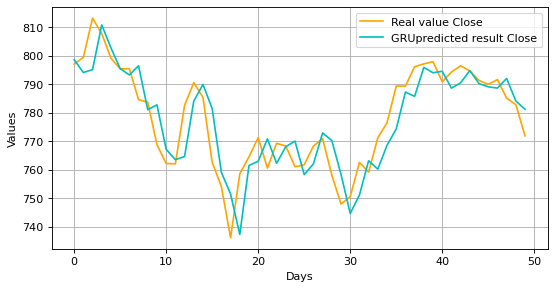

For number of timestep = 10,the RMSE plot


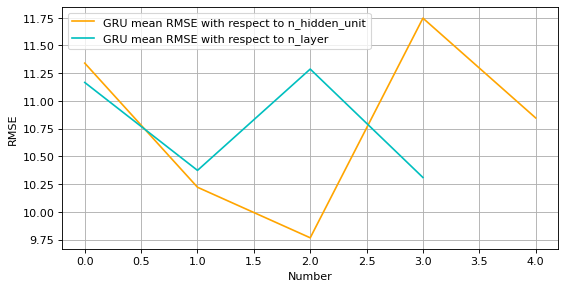

For number of timestep = 10,the training loss and val loss


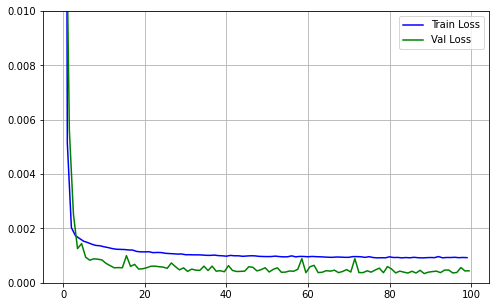

For number of timestep = 20,the best model RMSE is 8.749438398174577
For number of timestep = 20,the best hyperparameter setting is     number of hidden unit:100,number of layer:4
For number of timestep = 20,the prediction against true value


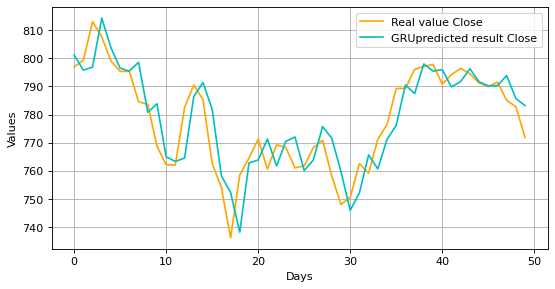

For number of timestep = 20,the RMSE plot


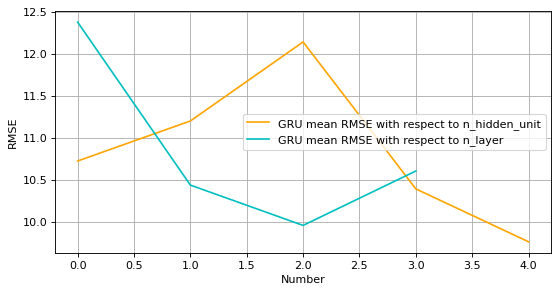

For number of timestep = 20,the training loss and val loss


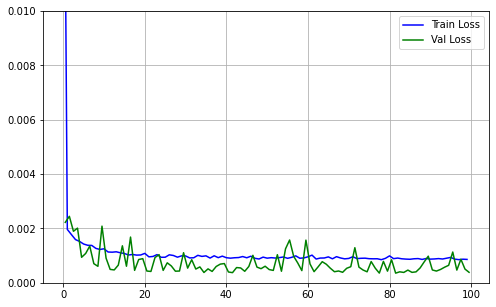

For number of timestep = 50,the best model RMSE is 8.76638132165457
For number of timestep = 50,the best hyperparameter setting is     number of hidden unit:50,number of layer:4
For number of timestep = 50,the prediction against true value


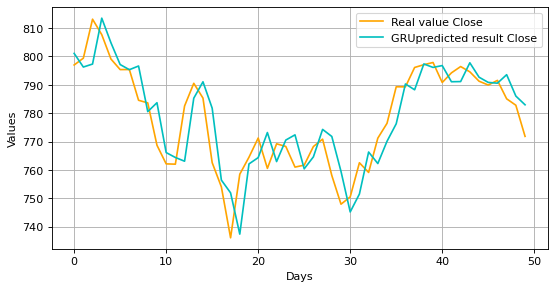

For number of timestep = 50,the RMSE plot


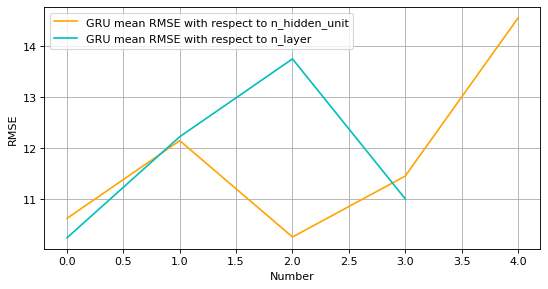

For number of timestep = 50,the training loss and val loss


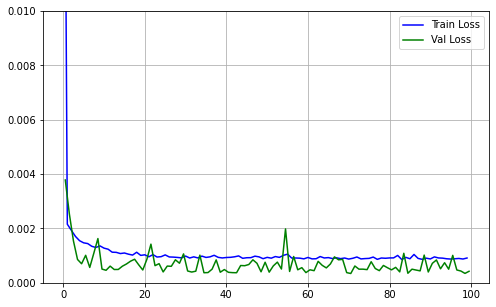

For number of timestep = 100,the best model RMSE is 8.596116217490353
For number of timestep = 100,the best hyperparameter setting is     number of hidden unit:20,number of layer:3
For number of timestep = 100,the prediction against true value


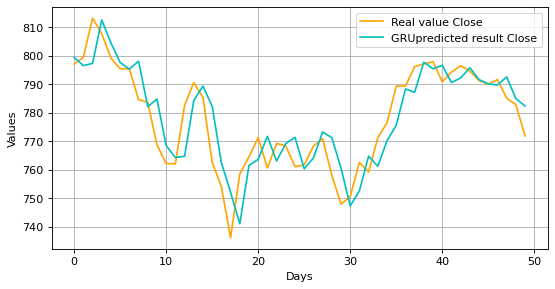

For number of timestep = 100,the RMSE plot


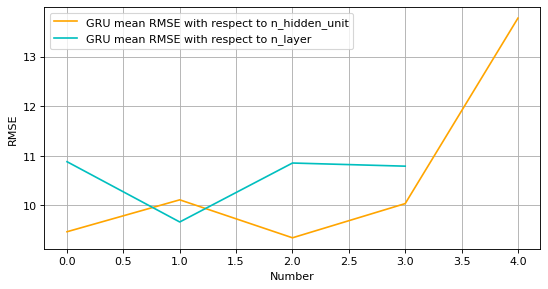

For number of timestep = 100,the training loss and val loss


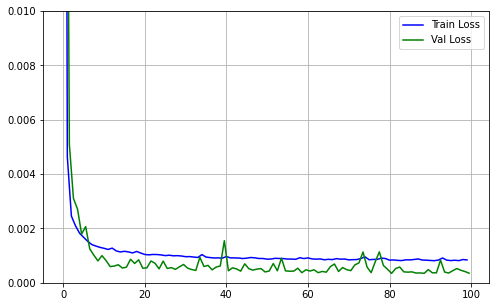

In [85]:
#For GRU
for n_timestep in n_timestep_list:

    train_set,val_set,test_set = Data_set_spliting(train_data,test_data,val_size,n_timestep)
    train_scaled,val_scaled,test_scaled,scaler = Data_scaling(train_set,val_set,test_set)

    X_train, y_train = generate_input_data(train_scaled, n_timestep)
    X_val, y_val = generate_input_data(val_scaled, n_timestep)
    X_test, y_test = generate_input_data(test_scaled, n_timestep)
    
    #grid search the model with different number of hidden unit and number of layer
    best_model,best_pred,lowest_RMSE,best_history,best_hyperparameter_list, RMSE_list, run_time  = Model_fit_pipeline(
        X_train = X_train, y_train = y_train, X_val= X_val, val_set = val_set, 
        RNN_cell = GRU, n_timestep = n_timestep, n_hidden_unit_list = n_hidden_unit_list, n_layer_list = n_layer_list)
    
    print(f'For number of timestep = {n_timestep},the best model RMSE is {lowest_RMSE}')
    print(f'For number of timestep = {n_timestep},the best hyperparameter setting is \
    number of hidden unit:{best_hyperparameter_list[0]},number of layer:{best_hyperparameter_list[1]}')
          
    print(f'For number of timestep = {n_timestep},the prediction against true value')
    plot_pred(best_pred,val_set,n_timestep,RNN_cell_label = 'GRU')
    print(f'For number of timestep = {n_timestep},the RMSE plot')
    plot_RMSE(RMSE_list,RNN_cell_label= 'GRU')
    print(f'For number of timestep = {n_timestep},the training loss and val loss')
    plot_history(best_history)
    

For number of timestep = 10,the best model RMSE is 8.981706889574765
For number of timestep = 10,the best hyperparameter setting is     number of hidden unit:200,number of layer:2
For number of timestep = 10,the prediction against true value


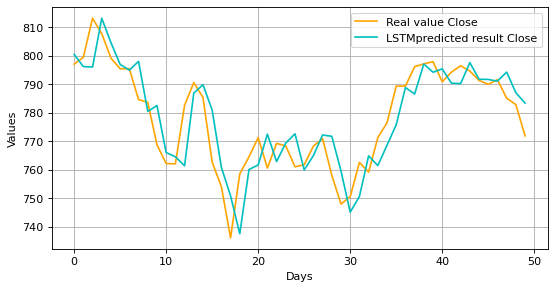

For number of timestep = 10,the RMSE plot


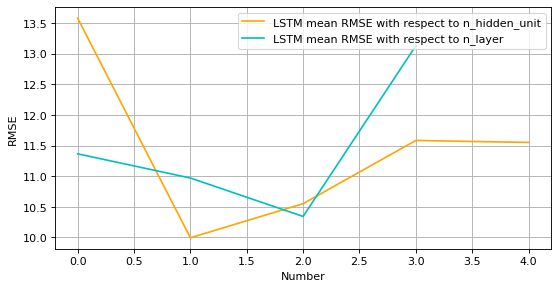

For number of timestep = 10,the training loss and val loss


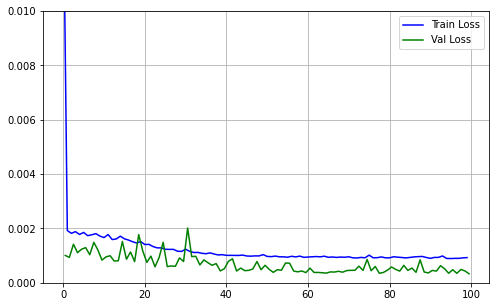

For number of timestep = 20,the best model RMSE is 8.763375416464033
For number of timestep = 20,the best hyperparameter setting is     number of hidden unit:200,number of layer:3
For number of timestep = 20,the prediction against true value


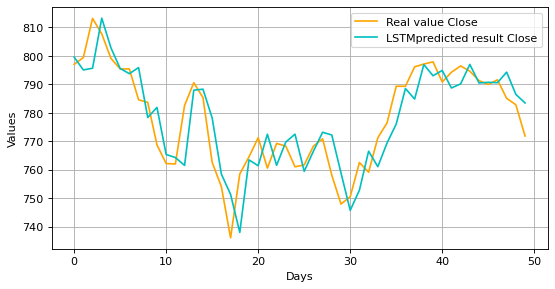

For number of timestep = 20,the RMSE plot


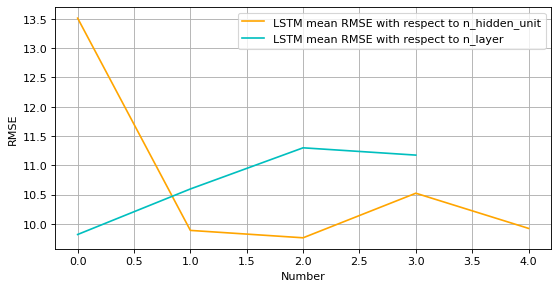

For number of timestep = 20,the training loss and val loss


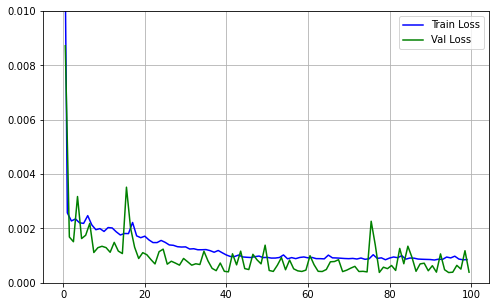

For number of timestep = 50,the best model RMSE is 9.027364396726846
For number of timestep = 50,the best hyperparameter setting is     number of hidden unit:20,number of layer:4
For number of timestep = 50,the prediction against true value


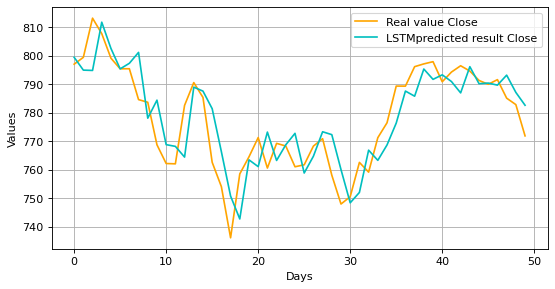

For number of timestep = 50,the RMSE plot


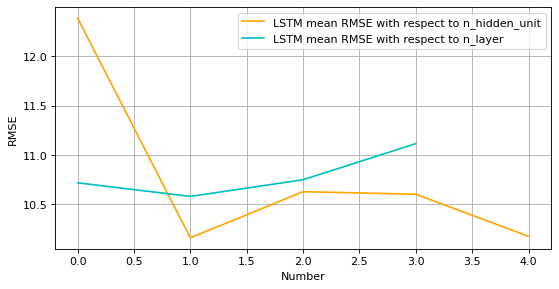

For number of timestep = 50,the training loss and val loss


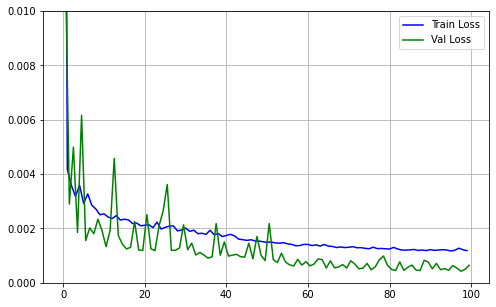

For number of timestep = 100,the best model RMSE is 8.776698831361966
For number of timestep = 100,the best hyperparameter setting is     number of hidden unit:100,number of layer:2
For number of timestep = 100,the prediction against true value


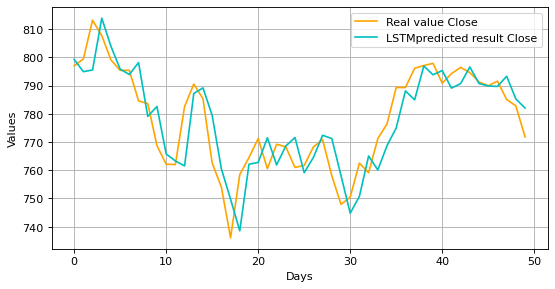

For number of timestep = 100,the RMSE plot


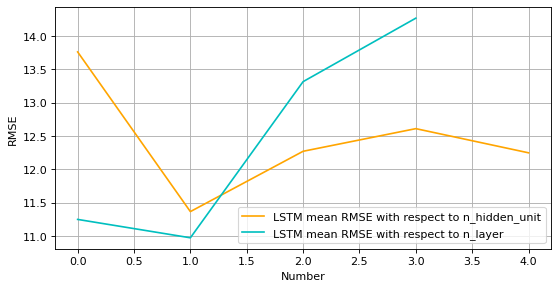

For number of timestep = 100,the training loss and val loss


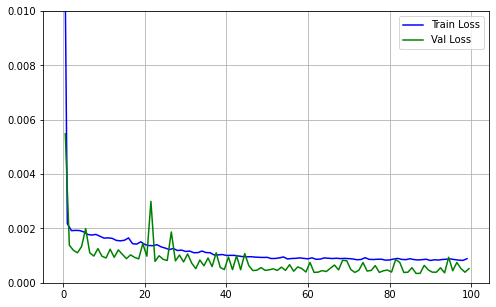

In [86]:
#For LSTM
for n_timestep in n_timestep_list:

    train_set,val_set,test_set = Data_set_spliting(train_data,test_data,val_size,n_timestep)
    train_scaled,val_scaled,test_scaled,scaler = Data_scaling(train_set,val_set,test_set)

    X_train, y_train = generate_input_data(train_scaled, n_timestep)
    X_val, y_val = generate_input_data(val_scaled, n_timestep)
    X_test, y_test = generate_input_data(test_scaled, n_timestep)
    
    #grid search the model with different number of hidden unit and number of layer
    best_model,best_pred,lowest_RMSE,best_history,best_hyperparameter_list, RMSE_list, run_time = Model_fit_pipeline(
        X_train = X_train, y_train = y_train, X_val= X_val, val_set = val_set, 
        RNN_cell = LSTM, n_timestep = n_timestep, n_hidden_unit_list = n_hidden_unit_list, n_layer_list = n_layer_list)
    
    print(f'For number of timestep = {n_timestep},the best model RMSE is {lowest_RMSE}')
    print(f'For number of timestep = {n_timestep},the best hyperparameter setting is \
    number of hidden unit:{best_hyperparameter_list[0]},number of layer:{best_hyperparameter_list[1]}')
          
    print(f'For number of timestep = {n_timestep},the prediction against true value')
    plot_pred(best_pred,val_set,n_timestep,RNN_cell_label = 'LSTM')
    print(f'For number of timestep = {n_timestep},the RMSE plot')
    plot_RMSE(RMSE_list,RNN_cell_label= 'LSTM')
    print(f'For number of timestep = {n_timestep},the training loss and val loss')
    plot_history(best_history)
    

Epoch 1/100
49/49 [==============================] - 1s 18ms/step - loss: 0.0602 - val_loss: 0.0459
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0074
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 8/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11

49/49 [==============================] - 0s 8ms/step - loss: 8.3213e-04 - val_loss: 3.3883e-04
Epoch 79/100
49/49 [==============================] - 0s 10ms/step - loss: 8.7374e-04 - val_loss: 5.0988e-04
Epoch 80/100
49/49 [==============================] - 1s 17ms/step - loss: 8.2054e-04 - val_loss: 6.2589e-04
Epoch 81/100
49/49 [==============================] - 1s 12ms/step - loss: 8.1736e-04 - val_loss: 5.7377e-04
Epoch 82/100
49/49 [==============================] - 1s 16ms/step - loss: 9.1318e-04 - val_loss: 5.8167e-04
Epoch 83/100
49/49 [==============================] - 1s 17ms/step - loss: 8.2908e-04 - val_loss: 3.9371e-04
Epoch 84/100
49/49 [==============================] - 1s 14ms/step - loss: 8.2895e-04 - val_loss: 4.9249e-04
Epoch 85/100
49/49 [==============================] - 0s 8ms/step - loss: 8.1408e-04 - val_loss: 2.4282e-04
Epoch 86/100
49/49 [==============================] - 1s 13ms/step - loss: 8.2189e-04 - val_loss: 2.6465e-04
Epoch 87/100
49/49 [==============

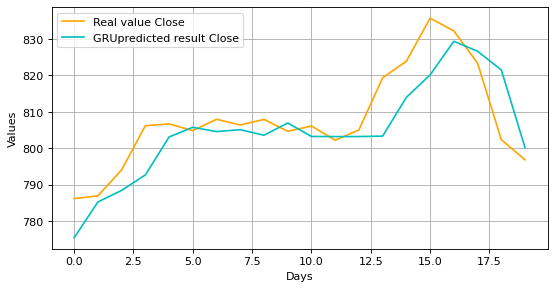

The training loss and val loss


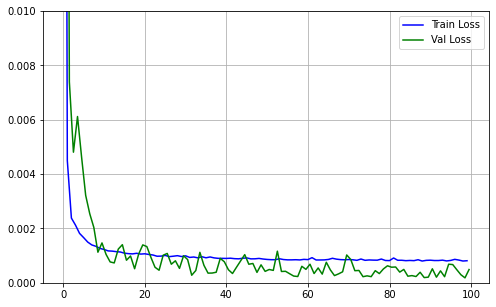

In [94]:
n_timestep = 100
n_hidden_unit = 20
n_layer = 3

train_set,val_set,test_set = Data_set_spliting(train_data,test_data,0,n_timestep)
train_scaled,val_scaled,test_scaled,scaler = Data_scaling(train_set,val_set,test_set)



X_train, y_train = generate_input_data(train_scaled, n_timestep)
#X_val, y_val = generate_input_data(val_scaled, n_timestep)
X_test, y_test = generate_input_data(test_scaled, n_timestep)
  
best_model = base_model(RNN_cell = GRU,n_hidden_unit = n_hidden_unit,n_layer = n_layer, n_timestep = n_timestep, n_feature = 5)

history = best_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs = 100, batch_size = 24,verbose=1)

y_pred = best_model.predict_step(X_test)
y_pred = scaler.inverse_transform(y_pred)
MSE = mean_squared_error(test_set[n_timestep:,3],y_pred[:,3])
RMSE = np.sqrt(MSE)
                        
                        
print(f'For number of timestep = {n_timepstep},the best model RMSE is {RMSE}')
print(f'The best hyperparameter setting is number of hidden unit:{n_hidden_unit},number of layer:{n_layer}')
          
print(f'The prediction against true value')
plot_pred(y_pred,test_set,n_timestep,RNN_cell_label = 'GRU')

print(f'The training loss and val loss')
plot_history(history)
    

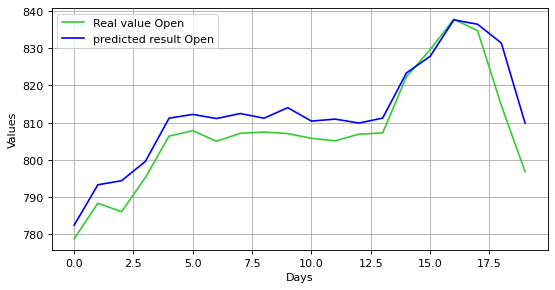

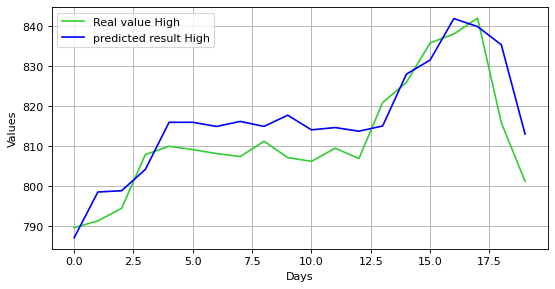

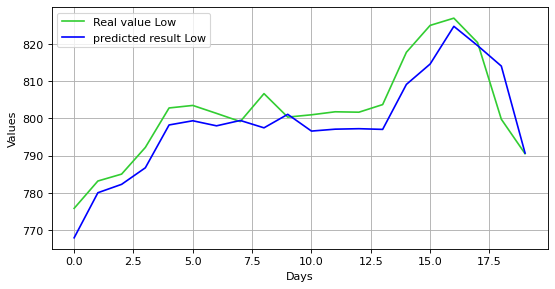

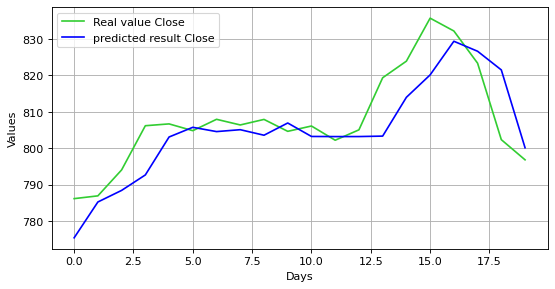

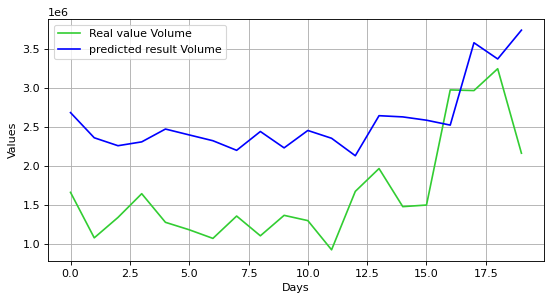

In [98]:
for i in range(5):
    plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(test_set[-20:,i],color="LimeGreen",label="Real value "+cols[i])
    
    #plt.plot(encoder_decoder_predict_last[:,i],color="Gold",label="RNN predicted result "+cols[i])
    #plt.plot(encoder_decoder_predict_last[:,i],color="Red",label="RNN predicted result "+cols[i])
    plt.plot(y_pred[:,i],color="Blue",label="predicted result "+cols[i])
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Values")
    plt.grid(True)
    plt.show()

In [102]:

def encoder_decoder_model(n_timesteps_in, n_features, n_hidden_unit = 50):
    
    encoder_inputs = Input(shape=(n_timesteps_in,n_features))
    encoder_LSTM = LSTM(n_hidden_unit,return_state=True, return_sequences = True, dropout=0.0)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    decoder_inputs = Input(shape=(n_timesteps_in,n_features))
    decoder_LSTM = LSTM(n_hidden_unit,return_state=True, return_sequences = True,dropout=0.0)
    decoder_outputs,_,_= decoder_LSTM(decoder_inputs, initial_state = encoder_states)
    #decoder_dense = TimeDistributed(Dense(1))
    decoder_dense = Dense(5)
    decoder_outputs = decoder_dense(decoder_outputs)
    
    training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    training_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    
    return training_model


In [105]:
n_timestep = 100
val_size = 50

train_set,val_set,test_set = Data_set_spliting(train_data,test_data,val_size,n_timestep)
train_scaled,val_scaled,test_scaled,scaler = Data_scaling(train_set,val_set,test_set)

X_train, y_train = generate_input_data(train_scaled, n_timestep)
X_val, y_val = generate_input_data(val_scaled, n_timestep)
X_test, y_test = generate_input_data(test_scaled, n_timestep)

train_model = encoder_decoder_model(n_timesteps_in = n_timestep, n_features=5,n_hidden_unit = 100)

train_model.fit([X_train,X_train], y_train, epochs=100, batch_size=1)
history = train_model.fit([X_train,X_train], y_train,validation_data=(X_val, y_val), epochs = 100, batch_size = 24,verbose=1)


Epoch 1/100
1108/1108 [==============================] - 10s 9ms/step - loss: 0.0087
Epoch 2/100
1108/1108 [==============================] - 14s 13ms/step - loss: 0.0068
Epoch 3/100
1108/1108 [==============================] - 11s 10ms/step - loss: 0.0052
Epoch 4/100
1108/1108 [==============================] - 9s 8ms/step - loss: 0.0037
Epoch 5/100
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 6/100
1108/1108 [==============================] - 12s 11ms/step - loss: 0.0027
Epoch 7/100
1108/1108 [==============================] - 13s 11ms/step - loss: 0.0023
Epoch 8/100
1108/1108 [==============================] - 13s 12ms/step - loss: 0.0021
Epoch 9/100
1108/1108 [==============================] - 11s 10ms/step - loss: 0.0019
Epoch 10/100
1108/1108 [==============================] - 12s 11ms/step - loss: 0.0018
Epoch 11/100
1108/1108 [==============================] - 13s 12ms/step - loss: 0.0018
Epoch 12/100
1108/1108 [==============================] -

1108/1108 [==============================] - 11s 10ms/step - loss: 7.8788e-04
Epoch 94/100
1108/1108 [==============================] - 10s 9ms/step - loss: 8.1060e-04
Epoch 95/100
1108/1108 [==============================] - 9s 8ms/step - loss: 7.4227e-04
Epoch 96/100
1108/1108 [==============================] - 9s 8ms/step - loss: 7.9209e-04
Epoch 97/100
1108/1108 [==============================] - 7s 6ms/step - loss: 7.4465e-04
Epoch 98/100
1108/1108 [==============================] - 7s 6ms/step - loss: 7.5093e-04
Epoch 99/100
1108/1108 [==============================] - 11s 10ms/step - loss: 8.0747e-04
Epoch 100/100
1108/1108 [==============================] - 6s 6ms/step - loss: 7.5133e-04
Epoch 1/100


InvalidArgumentError:  Incompatible shapes: [24,5] vs. [24,100,5]
	 [[node mean_squared_error/SquaredDifference (defined at <ipython-input-105-75f082c3d892>:14) ]] [Op:__inference_train_function_10317880]

Function call stack:
train_function


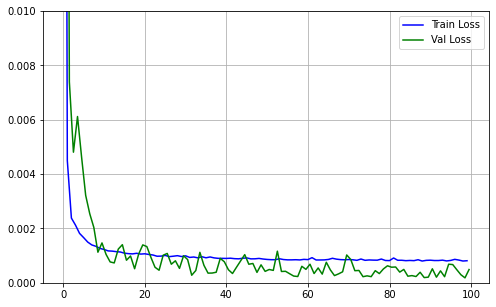

In [106]:
plot_history(history)

Number of timestep is 100,the RMSE is 10.262843297138813
The prediction against true value


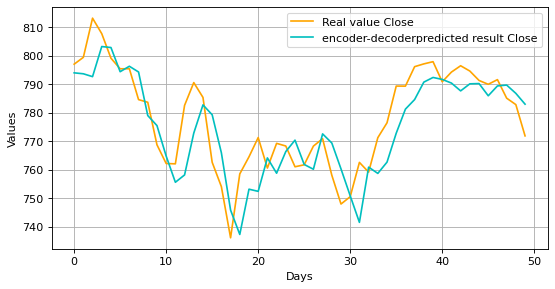

In [119]:
encoder_decoder_predict_val = train_model.predict([X_val,X_val])

#print(encoder_decoder_predict_val[:,-1].shape)
encoder_decoder_predict_val= scaler.inverse_transform(encoder_decoder_predict_val[:,-1])
#print(encoder_decoder_predict_val.shape)


MSE = mean_squared_error(val_set[n_timestep:,3],encoder_decoder_predict_val[:,3])
RMSE = np.sqrt(MSE)                  
                        
print(f'Number of timestep is {n_timepstep},the RMSE is {RMSE}')
         
print(f'The prediction against true value')
plot_pred(encoder_decoder_predict_val,val_set,n_timestep,RNN_cell_label = 'encoder-decoder')
